In [17]:
%matplotlib inline
import pandas as pd
import numpy as np

import tensorflow.keras.backend as K

import matplotlib.pyplot as plt

# \[ 문제 정의 \]
----
----

* 우리는 단어가 적혀진 이미지를 받아서, 철자의 순서에 따라 단어를 반환하는 모델입니다. 
* 최종 목표는 한글 단어가 적혀진 이미지를 받아, 한글 철자를 반환하도록 만드는 것입니다. 

## 1. MNIST를 활용하여, 문자 Sequence 만들기
----

* 우선 MNIST 데이터셋을 통해 Synthetic Dataset을 만들어서 데이터셋을 만들어 보도록 하겠습니다. Mnist로 가상의 데이터셋을 만든다면, 우리는 데이터의 부재 혹은 잘못된 라벨링으로 생겨나는 많은 문제들을 미연에 피할 수 있습니다.

### (1) Mnist 데이터셋 가져오기

In [41]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")
train_images, train_labels = mnist.train.images, mnist.train.labels
train_images = train_images.reshape(-1,28,28)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


### (2) 가로로 일열로 붙이기

/Users/ksj/anaconda3/lib/python3.6/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


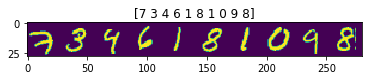

In [51]:
dummy_images = train_images[0:10]
dummy_labels = train_labels[0:10]

dummy_images = (dummy_images
                .transpose(1,0,2) # shape : (높이, 배치, 너비)
                .reshape(28,-1))  # shape : (높이, 배치 * 너비)

plt.title(dummy_labels)
plt.imshow(dummy_images)
plt.show()

일상 생활의 대부분 필기체 혹은 단어는 위와 같이 등간격으로 이루어져있지 않습니다. 그리고, 철자가 위아래로 반듯하게 쓰지도 않습니다. Synthetic Dataset에는 약간의 위치 노이즈가 필수적으로 들어가야 합니다.
1. 글자 간 간격이 비균일하게 만들어야 함

### (3) 철자의 위치를 무작위로 배치하는 메소드 구현하기

In [49]:
def serialize_random(images, pad_range=(3,15)):
    """
    복수의 이미지를 직렬로 붙이는 메소드 구현
    """
    pad_height = images.shape[1]
    pad_width = np.random.randint(*pad_range)
    
    # 첫 철자 앞의 공백
    serialized_image = np.zeros([pad_height, pad_width])
    for image in images:
        serialized_image = place_random(image, serialized_image, pad_range)
    serialized_image = np.clip(serialized_image, 0., 1.)
    return serialized_image

def place_random(image, serialized_image, pad_range):
    """
    가운데 정렬된 이미지를 떼어서 재정렬함
    """
    # set the threshold to 0.1 for reducing the noise
    positions = np.argwhere(
        image >= 0.1)
    y_min, x_min = positions.min(axis=0)
    y_max, x_max = positions.max(axis=0)
    cropped = image[:, x_min:x_max]

    pad_height = cropped.shape[0]
    pad_width = np.random.randint(*pad_range)
    pad = np.zeros([pad_height, pad_width])

    serialized_image = np.concatenate(
        [serialized_image, cropped, pad], axis=1)
    return serialized_image


/Users/ksj/anaconda3/lib/python3.6/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


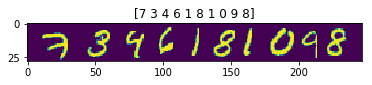

In [53]:
plt.title(train_labels[0:10])
plt.imshow(serialize_random(train_images[0:10]))
plt.show()

위의 데이터 셋을 활용하여 모델을 1차적으로 학습시켜 보도록 하겠습니다.

----

# \[ 한글 데이터셋 구성하기 \]
---
----

한글 이미지를 만들어주는 `OCRDataset` Class를 이용해보도록 하겠습니다.


In [3]:
%matplotlib inline
import sys
sys.path.append("../")
from utils.dataset import OCRDataset
import matplotlib.pyplot as plt

## 1. 한글 matplotlib 출력 세팅

In [4]:
# 1. 나눔 폰트를 다운받기
!apt-get update -qq
!apt-get install fonts-nanum* -qq

import matplotlib.font_manager as fm
# 2. 나눔 폰트의 위치 가져오기 
system_font = fm.findSystemFonts() # 현재 시스템에 설치된 폰트
nanum_fonts = [font for font in system_font if "NanumBarunGothic.ttf" in font]
font_path = nanum_fonts[0] # 설정할 폰트의 경로

# 3. 나눔 폰트로 설정하기
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
plt.rc("font",family=font_name)

# 4. 폰트 재설정하기
fm._rebuild()

# 5. (optional) minus 기호 깨짐 방지
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False


/bin/sh: apt-get: command not found
/bin/sh: apt-get: command not found


## 2. 한글 단어 자료 가져오기

In [8]:
import pandas as pd
import numpy as np

In [10]:
# 단어 최소/최대 길이
min_words = 4
max_words = 8

df = pd.read_csv("../datasets/wordslist.txt",names=['word'])
df = df.drop_duplicates()
df = df[df.word.str.match(r'^[가-힣]+$')]
df = df[
    df.word.map(
        lambda x: (len(x) >= min_words) 
        and (len(x) <= max_words))]
words = df.word.values
np.random.shuffle(words)
words

array(['민사슴지의', '너나들이', '에톡시드', ..., '이두한유', '역사문법', '전화가입권'],
      dtype=object)

## 3. 한글 이미지 만들기

In [15]:
dataset = OCRDataset(words, font_size=24)

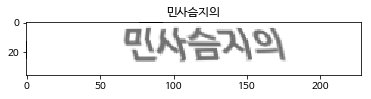

In [18]:
image, label = dataset[0]

plt.title(label)
plt.imshow(image[:,:,0],cmap='gray')
plt.show()

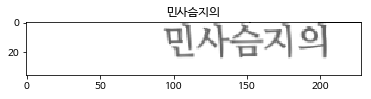

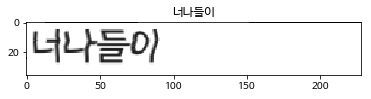

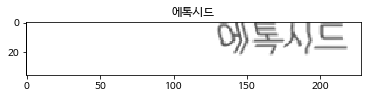

In [19]:
images, labels = dataset[0:3]

for image, label in zip(images, labels):
    plt.title(label)
    plt.imshow(image[:,:,0],cmap='gray')
    plt.show()
